# TD3 : Prototypage d'un modèle CTRNN

## I. Architecture CTRNN

In [9]:
import torch
import torch.nn as nn
import numpy as np

dt = 0.1
output_size = 12

class CTRNN(nn.Module):
    
    def __init__(self, hidden_size=50, tau=1.0):
        super().__init__()
        self.hidden_size = hidden_size
        self.tau = tau
        # Poids synaptiques
        self.I = nn.Linear(1, hidden_size, bias=False)
        self.H = nn.Linear(hidden_size, hidden_size, bias=False)
        self.O = nn.Linear(hidden_size, output_size, bias=False)
        # Biais explicites
        self.v = nn.Parameter(torch.zeros(hidden_size))
        self.m = nn.Parameter(torch.zeros(output_size))

    def forward(self, x, T):
        batch_size = x.shape[0]
        # Initialisation
        u = torch.zeros(batch_size, self.hidden_size, device=x.device)
        z = torch.zeros(batch_size, self.hidden_size, device=x.device)
        Y = []
        # Boucle temporelle
        for t in range(T):
            u = (1 - 1 / self.tau) * u + (1 / self.tau) * (self.I(x) + self.H(z) + self.v)
            z = torch.tanh(u)
            y = torch.sigmoid(self.O(z) + self.m)
            Y.append(y)
        return torch.stack(Y, dim=1)

def train_model(model, epochs=100, lr=1e-3, criterion=torch.nn.MSELoss()):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    # Loading dataset
    D = []
    for file in ["Q0.npy", "Q1.npy", "Q2.npy"]:
        data = np.load(file).to(device)
        D.append(torch.tensor(data, dtype=torch.float32))
    s_values = torch.tensor([[0.1], [0.5], [0.9]]) 
    indices = [0, 1, 2]  # index des primitives
    # Training loop
    for e in range(epochs):
        loss = 0.0
        optimizer.zero_grad()
        for idx in torch.randperm(len(indices)):
            j = indices[idx]
            sj = s_values[j].view(1,1).repeat(D[j].shape[0], 1)
            Y = model.forward(sj, D[j].shape[1])
            loss = loss + criterion(Y, D[j])
        loss.backward()
        optimizer.step()
        print(f"Epoch {e} | loss = {loss.item():.6f}")

In [10]:
# Charger un fichier de test
Q0 = torch.tensor(np.load("TD3-nao-CTRNN/controllers/my_controller/dataset/p0.npy"), dtype=torch.float32)
Q1 = torch.tensor(np.load("TD3-nao-CTRNN/controllers/my_controller/dataset/p1.npy"), dtype=torch.float32)

# Créer le modèle
model = CTRNN(hidden_size=50, tau=1.0)

# Sélectionner une primitive et créer son biais
sj = torch.tensor([[0.1]], dtype=torch.float32).repeat(Q0.shape[0], 1)  # batch = nombre de séquences

# Forward
T = Q0.shape[1]  # longueur temporelle = 60
Y = model.forward(sj, T)

print("Shape de Y:", Y.shape)  # doit être (batch_size, T, 10)
print("Exemple de sortie Y[0, :5]:", Y[0, :5])

Shape de Y: torch.Size([60, 12, 12])
Exemple de sortie Y[0, :5]: tensor([[0.4973, 0.5053, 0.4855, 0.5009, 0.4960, 0.5080, 0.4989, 0.4906, 0.5013,
         0.4946, 0.5069, 0.4900],
        [0.4963, 0.4919, 0.4820, 0.5031, 0.4975, 0.5046, 0.5012, 0.4872, 0.5026,
         0.4858, 0.4983, 0.4936],
        [0.4916, 0.4947, 0.4806, 0.5039, 0.4976, 0.5065, 0.5028, 0.4875, 0.4994,
         0.4864, 0.4997, 0.4953],
        [0.4923, 0.4944, 0.4813, 0.5029, 0.4948, 0.5056, 0.5014, 0.4889, 0.5003,
         0.4865, 0.4988, 0.4953],
        [0.4927, 0.4943, 0.4815, 0.5029, 0.4949, 0.5055, 0.5015, 0.4892, 0.5008,
         0.4874, 0.4983, 0.4950]], grad_fn=<SliceBackward0>)


torch.Size([1, 1, 60, 12])
shape: torch.Size([1, 1, 60, 12])
min: tensor([[[0.5025, 0.6434, 0.9309, 0.3053, 0.0876, 0.9533, 0.5098, 0.5520,
          0.4044, 0.8552, 0.5838, 0.4000],
         [0.5025, 0.6436, 0.9310, 0.3052, 0.0876, 0.9534, 0.5098, 0.5519,
          0.4143, 0.8562, 0.6342, 0.3999],
         [0.5025, 0.6439, 0.9310, 0.3051, 0.0876, 0.9534, 0.5098, 0.5517,
          0.4244, 0.8572, 0.6851, 0.3999],
         [0.5025, 0.6441, 0.9310, 0.3051, 0.0876, 0.9534, 0.5098, 0.5516,
          0.4337, 0.8582, 0.7323, 0.3999],
         [0.5025, 0.6443, 0.9310, 0.3051, 0.0876, 0.9534, 0.5098, 0.5515,
          0.4414, 0.8590, 0.7716, 0.3999],
         [0.5025, 0.6444, 0.9310, 0.3051, 0.0876, 0.9534, 0.5098, 0.5514,
          0.4477, 0.8596, 0.8032, 0.3999],
         [0.5025, 0.6444, 0.9310, 0.3051, 0.0876, 0.9533, 0.5098, 0.5514,
          0.4490, 0.8598, 0.8097, 0.3999],
         [0.5025, 0.6443, 0.9309, 0.3051, 0.0876, 0.9533, 0.5098, 0.5514,
          0.4469, 0.8596, 0.7991, 0.3999]

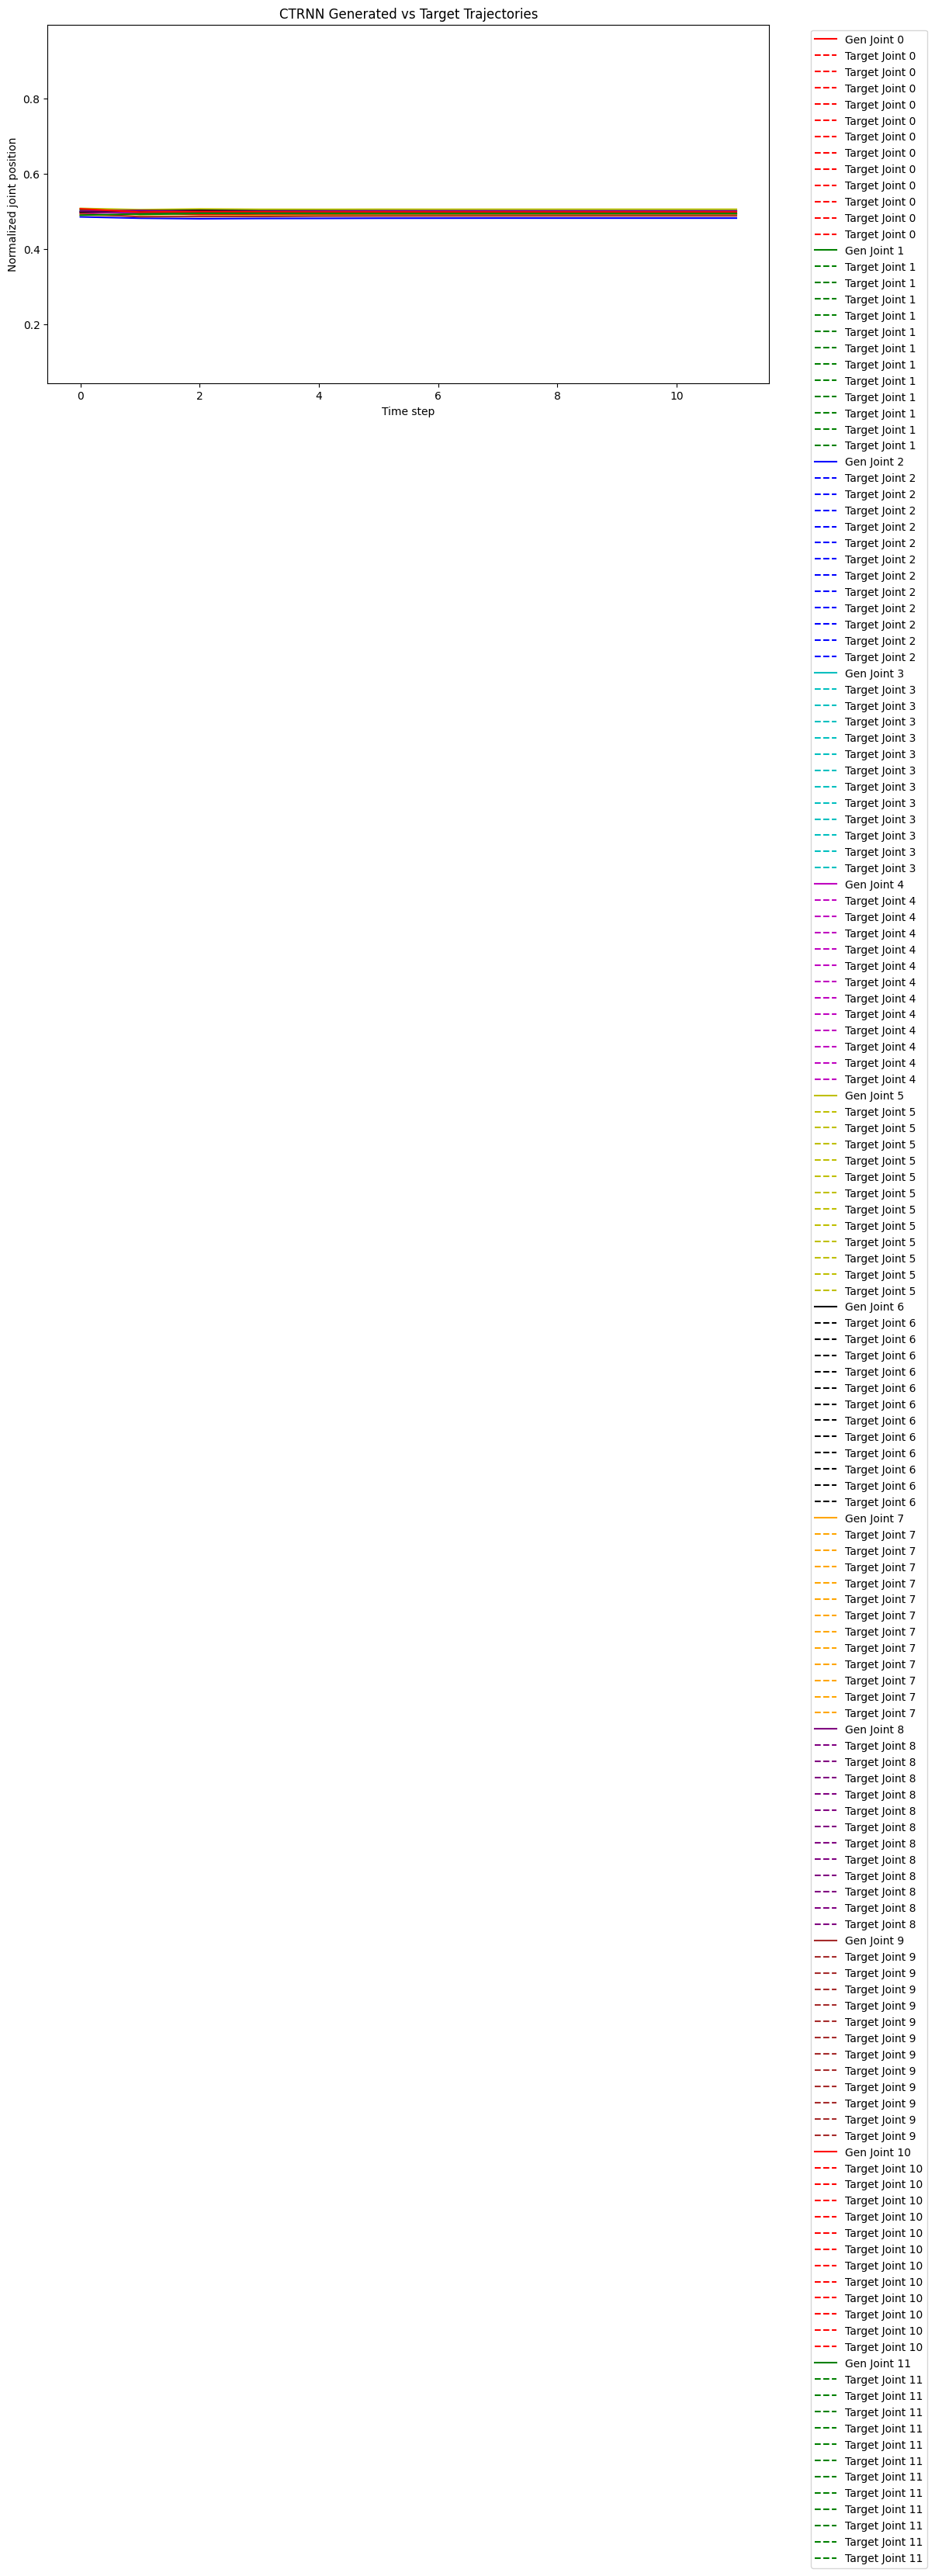

In [14]:
import matplotlib.pyplot as plt

# Sélectionner la première séquence
seq_index = 0

colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k', 'orange', 'purple', 'brown', 'r', 'g']

Q0 = Q0.unsqueeze(0)

print(Q0.shape)
print("shape:", Q0.shape)
print("min:", Q0.min(0).values)
print("max:", Q0.max(0).values)

print(type(Q0))
print(Q0.shape)
print(Q0.dtype)
print(Q0[:5])

print(type(Q1))
print(Q1.shape)
print(Q1.dtype)
print(Q1[:5])


plt.figure(figsize=(12, 6))
for joint in range(12):
    plt.plot(Y[seq_index, :, joint].detach().cpu().tolist(),
             color=colors[joint], linestyle='-', label=f'Gen Joint {joint}')
    plt.plot(Q0[seq_index, :, joint].cpu().tolist(),
             color=colors[joint], linestyle='--', label=f'Target Joint {joint}')

plt.xlabel('Time step')
plt.ylabel('Normalized joint position')
plt.title('CTRNN Generated vs Target Trajectories')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()
